In [3]:
# 이 모듈은 다른 운영 체제에 적합한 의미 체계를 가진 파일 시스템 경로를 나타내는 클래스를 제공 (단순한 경로가 아닌 객체로 다룬다)
from pathlib import Path
# 온라인 서비스를 HTTP로 호출하면 상태 코드를 응답받게 된다
import requests

# 만들 파일 경로 설정하고
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

# 폴더 만듬
PATH.mkdir(parents=True, exist_ok=True)

In [4]:
# 다운받을 링크
URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
# 파일 이름
FILENAME = "mnist.pkl.gz"

# 경로에 파일이 존재하지 않으면 실행
if not (PATH / FILENAME).exists():
        # 내용 가져오기
        content = requests.get(URL + FILENAME).content
        # 바이너리 형태로 열고 가져온 내용을 써라
        (PATH / FILENAME).open("wb").write(content)

In [9]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
        print(f"x_train : {x_train} \n x_valid : {x_valid}")
        print(f"y_train : {y_train} \n y_valid : {y_valid}")

x_train : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 
 x_valid : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
y_train : [5 0 4 ... 8 4 8] 
 y_valid : [3 8 6 ... 5 6 8]


(50000, 784)


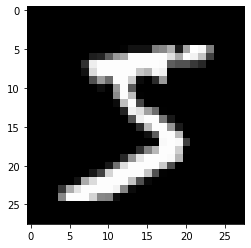

In [6]:
from matplotlib import pyplot
import numpy as np

# 각 이미지는 28 x 28 형태 이고, 784 (=28x28) 크기를 가진 하나의 행으로 저장되어 있다. 
# 이 이미지를 2d로 재구성해야 한다.
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [16]:
import torch

# PyTorch는 numpy 배열 보다는 torch.tensor 를 사용하므로, 데이터를 변환해야 한다.
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


/tmp/ipykernel_2246/2040583167.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


In [21]:
# 텐서 연산만으로 첫 모델을 만들기.
import math
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
print(weights)
bias = torch.zeros(10, requires_grad=True)
print(bias)

tensor([[-0.0250, -0.0193, -0.0573,  ...,  0.0157, -0.0024,  0.0048],
        [ 0.0163,  0.0374,  0.0366,  ..., -0.0492, -0.0039,  0.0361],
        [-0.0493, -0.0600,  0.0100,  ...,  0.0223, -0.0022,  0.0142],
        ...,
        [-0.0470,  0.0647, -0.0490,  ..., -0.0100,  0.0072, -0.0480],
        [-0.0157, -0.0117, -0.0167,  ..., -0.0454, -0.0294, -0.0096],
        [ 0.0121, -0.0216, -0.0172,  ..., -0.0101, -0.0187, -0.0370]],
       requires_grad=True)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
torch.manual_seed(1)

In [24]:
# 데이터
x_train = torch.FloatTensor([[73, 80, 75],
                             [93, 88, 93],
                             [89, 91, 90],
                             [96, 98, 100],
                             [73, 66, 70]])
y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])

In [25]:
class MultivariateLinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1) # 다중 선형 회귀이므로 input_dim=3, output_dim=1.

    def forward(self, x):
        return self.linear(x)

In [26]:
model = MultivariateLinearRegressionModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 

In [29]:
nb_epochs = 2000
for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(x_train)
    # model(x_train)은 model.forward(x_train)와 동일함.

    # cost 계산
    cost = F.mse_loss(prediction, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    # cost로 H(x) 개선하는 부분
    # gradient를 0으로 초기화
    optimizer.zero_grad()
    # 비용 함수를 미분하여 gradient 계산
    cost.backward()
    # W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))

this is a prediction :  tensor([[151.2305],
        [184.8005],
        [180.5203],
        [196.3101],
        [141.9926]], grad_fn=<AddmmBackward0>)
Epoch    0/2000 Cost: 0.199759
this is a prediction :  tensor([[151.2306],
        [184.8004],
        [180.5203],
        [196.3101],
        [141.9925]], grad_fn=<AddmmBackward0>)
this is a prediction :  tensor([[151.2306],
        [184.8004],
        [180.5203],
        [196.3101],
        [141.9925]], grad_fn=<AddmmBackward0>)
this is a prediction :  tensor([[151.2307],
        [184.8004],
        [180.5204],
        [196.3101],
        [141.9925]], grad_fn=<AddmmBackward0>)
this is a prediction :  tensor([[151.2307],
        [184.8003],
        [180.5204],
        [196.3101],
        [141.9924]], grad_fn=<AddmmBackward0>)
this is a prediction :  tensor([[151.2308],
        [184.8003],
        [180.5204],
        [196.3101],
        [141.9924]], grad_fn=<AddmmBackward0>)
this is a prediction :  tensor([[151.2308],
        [184.8003],